In [32]:
import numpy as np
import csv,json
import pandas as pd
# mute the warnings
import warnings
warnings.filterwarnings("ignore")
import nltk.data
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata
from nltk import tokenize

# (1) Data Preparation

In [2]:
# See the script(Data_collect_preparation)
df_stocks = pd.read_pickle('pickled_twenty_year_filtered_lead_para.pkl')

# (2) Data Statistics

In [ ]:
# See script(data_stats) for 

# (3) BaseLine 1: Vader

In [ ]:
# See the other script For Baseline 1

# (4) BaseLine 2: Train Multiple-Linear Regression model on the words sentiment

In [64]:
# Clean the Text file
s = stopwords.words("english")
def clean_review(review, remove_stopwords = False):
    """
     Arg: review: review string (str)
          remove_stopwards: If true remove stopwords else not. (boolean)
     Returns: cleaned_review : Cleaned review (list)

     You should carry out the following steps.
     1. Remove HTML Tags.
     2. Remove non-letter characters.
     3. Convert to lower case.
    """
    ### Add your code here.
    #Removing HTML Markup: The BeautifulSoup Package, a stable way to remove HTML tags
    X1 = BeautifulSoup(review).get_text()
    X2 = re.sub("[^a-zA-Z]"," ",X1) # Substitue all non-letters with empty.
    X3 = X2.lower().split() # transform to lower case and then split into list
    cleaned_review = X3
    if remove_stopwords:
        global s
        X4 = [w for w in X3 if not w in s]
        cleaned_review = X4
    #####################
    
    return cleaned_review

def Get_Data(Price_col_name,News_col_name,Data,n_days):
    
    '''
    Use the input Data to get the n_days Log_return
    The output data is only with two columns log_return and news
    
    input: n_days(list) with long term, mid term and short term return days
    '''
    L = []
    for j in n_days:
        Data[str(j)+'days'+'_LogReturn'] = np.log(Data[Price_col_name]).shift(-j)-np.log(Data[Price_col_name])
        L.append(str(j)+'days'+'_LogReturn')

    Data = Data.dropna()
    
    Data['News'] = ''
    for i in range(len(Data)):
        Data['News'][i] = clean_review(Data[News_col_name][i],True)
    
    L.append('News')
    Data = Data[L]
    return Data

In [65]:
# Get the cleaned data
Data = Get_Data('adj close','articles',df_stocks,[3,10,22])

In [95]:
# Get the Vocaublary Statistics
vocabulary = set()
for i in range(0 ,len(Data)):
    line = Data['News'].values[i]
#     print(line)
    words = line
#     print(words)
    for word in words:
        if word not in vocabulary:
            vocabulary.add(word)
print (len(vocabulary))

164778


In [116]:
# Use 3000 vocabularies as Words vector
D = dict()
V = list(vocabulary)
for i in V:
    D[i] = 0
for i in range(len(Data)):
    for j in Data['News'][i]:
        D[j] = D[j]+1

sorted_D = sorted(D.items(), key=lambda kv: kv[1])
sorted_D = sorted_D[161778:]
V_y = [i[0] for i in sorted_D]
len(V_y)

In [181]:
# Construct the word vector for everyday
# It takes almost an hour on my computer
n = len(V_y)
Data['Bag_of_Words'] = ''
for i in range(len(Data)):
    temp = np.zeros(n)
    if i%1000==0:
        display(i)
    for j in Data['News'][i]:
        for k in range(len(V_y)):
            if V_y[k]==j:
                temp[k] = temp[k]+1
    Data['Bag_of_Words'][i] = list(temp)

0

1000

2000

3000

4000

5000

6000

7000

In [205]:
# Drop those days with too little valid X variable
I = []
for i in range(len(Data)):
    if sum(Data['Bag_of_Words'][i])<50:
        
        I.append(Data.index[i])
Data.drop(I,inplace=True)

In [426]:
# 70% for train 30% for test
Train = Data.iloc[:5000,:]
Test = Data.iloc[5000:,:]
X_train = []
for i in range(len(Train)):
    X_train.append(Train['Bag_of_Words'][i])
X_train = np.array(X_train)
X_test = []
for i in range(len(Test)):
    X_test.append(Test['Bag_of_Words'][i])
X_test = np.array(X_test)

y1_train = np.array(Train['3days_LogReturn']).reshape(-1,1)
y2_train = np.array(Train['10days_LogReturn']).reshape(-1,1)
y3_train = np.array(Train['22days_LogReturn']).reshape(-1,1)
y1_test = np.array(Test['3days_LogReturn'])
y2_test = np.array(Test['10days_LogReturn'])
y3_test = np.array(Test['22days_LogReturn'])
from sklearn.linear_model import ElasticNet
enet1 = ElasticNet(alpha=0.00028)
enet2 = ElasticNet(alpha=0.00028)
enet3 = ElasticNet(alpha=0.00028)

Model_ElasticNet_Short_Term = enet1.fit(X_train,y1_train)
Model_ElasticNet_Med_Term = enet2.fit(X_train,y2_train)
Model_ElasticNet_Long_Term = enet3.fit(X_train,y3_train)

y_pred1 = Model_ElasticNet_Short_Term.predict(X_test) 
y_pred2 = Model_ElasticNet_Med_Term.predict(X_test)
y_pred3 = Model_ElasticNet_Long_Term.predict(X_test)

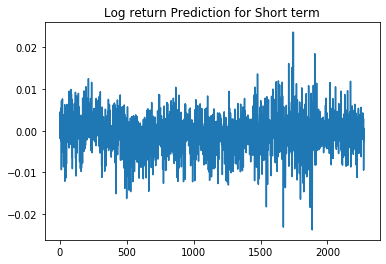

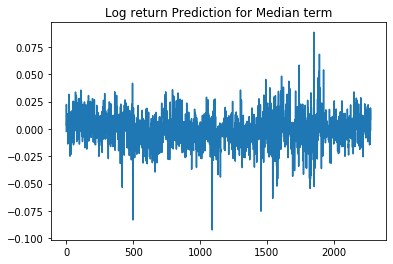

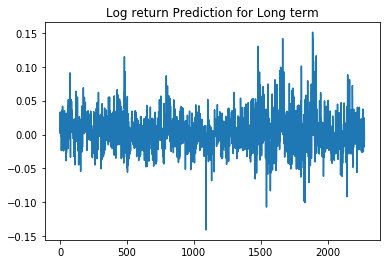

In [427]:
plt.plot(y_pred1)
plt.title('Log return Prediction for Short term')
plt.show()
plt.plot(y_pred2)
plt.title('Log return Prediction for Median term')
plt.show()
plt.plot(y_pred3)
plt.title('Log return Prediction for Long term')
plt.show()

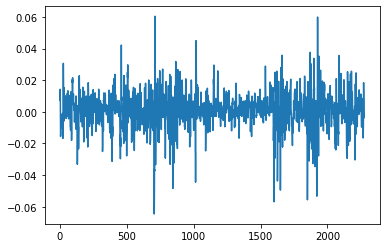

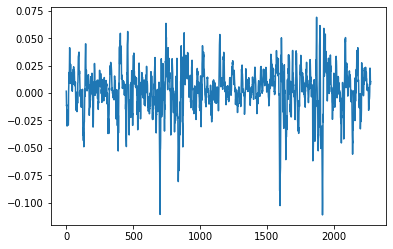

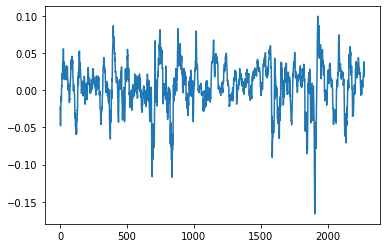

In [428]:
# Compared with real data
plt.plot(y1_test)
plt.show()
plt.plot(y2_test)
plt.show()
plt.plot(y3_test)
plt.show()

In [429]:
def Result_Analysis(y_real,y_predict):
    bias = np.mean(y_real-y_predict)
    MAE = np.mean(np.abs(y_real-y_predict))
    RMSE = np.sqrt(np.mean((y_real-y_predict)**2))
    y_bar = np.mean(y_real)
    SST = np.sum((y_real- y_bar)**2)
    SSReg = np.sum((y_predict - y_bar)**2)
    R_squared = SSReg/SST
    
    return bias, MAE, RMSE, R_squared

display('bias, MAE, RMSE, R_squared',Result_Analysis(y1_test,y_pred1))
display('bias, MAE, RMSE, R_squared',Result_Analysis(y2_test,y_pred2))
display('bias, MAE, RMSE, R_squared',Result_Analysis(y3_test,y_pred3))

'bias, MAE, RMSE, R_squared'

(0.0013289828793226072,
 0.009001623663649634,
 0.012352931292581566,
 0.1773851176954344)

'bias, MAE, RMSE, R_squared'

(0.0030778702063356,
 0.01896898735126335,
 0.024998436708915165,
 0.48685127077994944)

'bias, MAE, RMSE, R_squared'

(0.0022383334620492763,
 0.0296959189868414,
 0.03914166652452863,
 0.7618326685304048)